## Generate synthetic data using private marginals
---

#### Clean and get dataset and include important functions and packages

In [518]:
# get dataset
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

bear = pd.read_csv('https://raw.githubusercontent.com/jbennett979/Data_Privacy_FP/refs/heads/main/north_america_bear_killings.csv')

In [519]:
# Cleaning up the dataset
bear.columns = [c.lstrip() for c in bear]
# capitalizing columns name for age and gender
bear= bear.rename(columns={'age': 'Age'})
bear= bear.rename(columns={'gender': 'Gender'})
bear = bear.rename(columns={'Type': 'Captivity'})

bear['Age'] = pd.to_numeric(bear['Age'], errors = 'coerce')
bear

,Name,Age,Gender,Date,Month,Year,Captivity,Location,Description,Type of bear,Hunter,Grizzly,Hikers,Only one killed
0,Erin Johnson,27,female,6/19/2017,6,2017,Wild,"Pogo mine, Alaska","Johnson, a contract employee for Pogo Mine, wa...",Black bear,0,0,0,1
1,Patrick Cooper,16,male,6/18/2017,6,2017,Wild,"Indian, Alaska",Cooper was chased and mauled by a bear while r...,Black bear,0,0,0,1
2,Daniel Ward O'Connor,27,male,5/10/2015,5,2015,Wild,"near Mackenzie, British Columbia",Ward was killed by a bear while he slept near ...,Black bear,0,0,0,1
3,Darsh Patel,22,male,9/21/2014,9,2014,Wild,"near West Milford, New Jersey",Patel was about to begin hiking with four frie...,Black bear,0,0,1,1
4,Lorna Weafer,36,female,5/7/2014,5,2014,Wild,"near Fort McMurray, Alberta","Weafer, a Suncor worker was attacked at the re...",Black bear,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,Baby Laird,1,NaN,10/5/1908,10,1908,Captive,"Tucson, Arizona",After a bear escaped from a cage at Elysian Gr...,Black bear,0,0,0,1
160,John Dicht,18,male,11/24/1906,11,1906,Wild,"Elk County, Pennsylvania","Thinking the bear was dead, Dicht began skinni...",Black bear,0,0,0,1
161,Mary Porterfield,3,female,5/19/1901,5,1901,Wild,"Job, West Virginia",The children were gathering flowers near their...,Black bear,0,0,0,0
162,Wilie Porterfield,5,male,5/19/1901,5,1901,Wild,"Job, West Virginia",The children were gathering flowers near their...,Black bear,0,0,0,0


#### Functions to generate differentially private marginals

In [520]:
# calculates a differentially private one-way marginal for a given column
def dp_marginal(col, epsilon):
    hist = bear[col].value_counts()
    dp_hist = hist.apply(lambda x: laplace_mech(x, 1, epsilon))
    clipped = dp_hist.clip(lower=0)
    marginal = clipped / clipped.sum()
    return marginal

In [521]:
# one-way marginal for the age column
age_marg = dp_marginal('Age', 1.0)
hist = bear['Age'].value_counts() / len(bear['Age'])
df = pd.merge(hist, age_marg, on='Age').rename(columns={'count_x': 'Real_Age', 'count_y': 'Synth_Age'})
df['% Error'] = df.apply(lambda x: pct_error(x.Real_Age, x.Synth_Age), axis=1)
df
# age_marg

,Real_Age,Synth_Age,% Error
Age,,,
40,0.048780,0.062607,28.345091
24,0.036585,0.019200,47.520513
19,0.036585,0.027133,25.835236
37,0.036585,0.048586,32.802932
31,0.030488,0.012525,58.916812
...,...,...,...
23,0.006098,0.001071,82.443391
43,0.006098,0.006103,0.089211
8,0.006098,0.004897,19.689207


In [522]:
# one-way marginal for the type of bear column
dp_marginal('Type of bear', 1.0)

Type of bear
Brown bear    0.483552
Black bear    0.461535
Polar Bear    0.054913
Name: count, dtype: float64

In [523]:
# one-way marginal for if bear is a grizzly
dp_marginal('Grizzly', 1.0)

Grizzly
0    0.837289
1    0.162711
Name: count, dtype: float64

#### Generate synthetic data from one-way marginal

In [524]:
def gen_samples(n, marginal):
    samples = marginal.sample(n=n, replace=True, weights='probability')
    return samples.drop(columns='probability')

def dp_synthetic_data(cols, n, epsilon):
    epsilon_i = epsilon / len(cols)
    data_dict = {}

    for col in cols:
        marg = dp_marginal(col, epsilon_i).to_frame(name='probability')
        synth = marg.sample(n=n, replace=True, weights='probability').sort_index()

        synth = synth.index.to_series().reset_index(drop=True)
        data_dict[col] = synth

    return pd.concat(data_dict, axis=1)

dp_synthetic_data(['Age'], 20, 1.0)

,Age
0,1
1,3
2,3
3,12
4,15
5,18
6,24
7,25
8,28
9,29


#### Generate two-way marginals

In [525]:
# Generate a two way synthetic rep for age and type of bear
def two_way_bear_hist(col1, col2, epsilon):
    hist = bear[[col1, col2]].value_counts()
    dp_hist = hist.apply(lambda x: laplace_mech(x, sensitivity=1, epsilon=epsilon))
    return dp_hist.clip(lower=0)

def two_marginal(col1, col2, epsilon):
    syn_rep = two_way_bear_hist(col1, col2, epsilon)
    marginal = syn_rep / syn_rep.sum()
    return marginal.to_frame(name='probability').reset_index()

def gen_samples(n, marginal):
    samples = marginal.sample(n=n, replace=True, weights='probability')
    return samples.drop(columns='probability')

In [526]:
# two way marginal
marginal = two_marginal('Type of bear','Age', 1.0)
marginal

,Type of bear,Age,probability
0,Brown bear,40,0.050912
1,Black bear,24,0.016847
2,Brown bear,19,0.017282
3,Black bear,3,0.017737
4,Brown bear,38,0.038403
...,...,...,...
91,Polar Bear,29,0.000000
92,Polar Bear,31,0.007275
93,Polar Bear,43,0.005281
94,Polar Bear,46,0.001848


In [527]:
# two way marginal
marginal = two_marginal('Hunter','Age', 1.0)
gen_samples(15, marginal)

,Hunter,Age
45,0,77
33,0,48
35,0,44
25,0,6
8,0,1
18,0,61
33,0,48
4,0,28
39,0,59
67,0,74


#### Synthetic data with two-way marginals

In [528]:
def dp_synthetic_data_two_marginal(col1, col2, n, epsilon):
    # Age and type marginal
    age_type_marg = two_marginal(col1, col2, epsilon)

    samples = gen_samples(n, age_type_marg).sort_index()
    return samples

In [529]:
""" Synthetic data if the bear was a grizzly and the month the accident occurred """
# 160 samples to better compare the counts
synth = dp_synthetic_data_two_marginal('Grizzly', 'Month', 160, 1.0)

synth_month = len(synth[synth['Month'] == 7])
real_month = len(bear[bear['Month'] == 7])

print(f"Synthetic: {synth_month}, Real: {real_month}")
assert synth_month >= 15 and synth_month <= 35

Synthetic: 25, Real: 27


In [530]:
""" Synthetic data on type of bear and if they were in captivity """
# 160 samples to better compare the counts
synth = dp_synthetic_data_two_marginal('Type of bear', 'Captivity', 160, 1.0)

synth_wild = len(synth[synth['Captivity'] == 'Captive'])
real_wild = len(bear[bear['Captivity'] == 'Captive'])

print(f"Synthetic: {synth_wild}, Real: {real_wild}")
assert synth_wild >= 15 and synth_wild <= 40

Synthetic: 34, Real: 28


In [531]:
""" Synthetic data on age of person and if they were hunters """
# 160 samples to better compare the counts
synth = dp_synthetic_data_two_marginal('Age', 'Hunter', 160, 1.0)

synth_hunt = len(synth[synth['Hunter'] == 1])
real_hunt = len(bear[bear['Hunter'] == 1])

print(f"Synthetic: {synth_hunt}, Real: {real_hunt}")
assert synth_hunt >= 5 and synth_hunt <= 25

Synthetic: 25, Real: 15


Text(0.5, 1.0, '% Error in Synthetic Data from Grizzly and Month Columns')

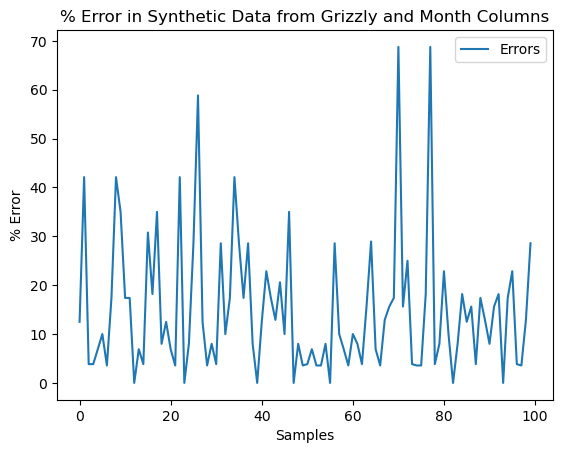

In [546]:
errors = []
for i in range(100):
    synth = dp_synthetic_data_two_marginal('Grizzly', 'Month', 160, 1.0)
    errors.append(pct_error(len(synth[synth['Month'] == 7]), len(bear[bear['Month'] == 7])))


plt.plot(errors, label='Errors')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('% Error')
plt.title('% Error in Synthetic Data from Grizzly and Month Columns')


15

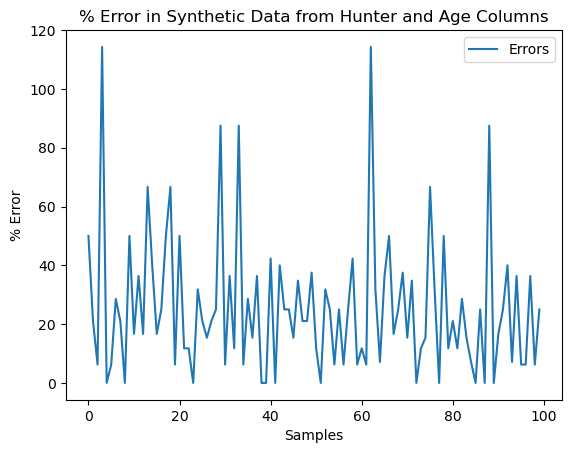

In [548]:
errors = []
for i in range(100):
    synth = dp_synthetic_data_two_marginal('Age', 'Hunter', 160, 1.0)
    errors.append(pct_error(len(synth[synth['Hunter'] == 1]), len(bear[bear['Hunter'] == 1])))


plt.plot(errors, label='Errors')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('% Error')
plt.title('% Error in Synthetic Data from Hunter and Age Columns')
len(bear[bear['Hunter'] == 1])